In [1]:
from __future__ import division

import numpy as np
import os
from glob import glob
import scipy

from PIL import Image
from copy import deepcopy

from sklearn import linear_model, datasets, neighbors
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import svm

%matplotlib inline
from scipy.misc import imread, imresize
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import torch
import torchvision.models as models
import torch.nn as nn
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.autograd import Variable

import pandas as pd
import pickle

VGG_SIZE_X = 224
VGG_SIZE_Y = 224
VGG_SIZE_Z = 3





In [14]:
def normalize(X, u, std):

    X = X - u
    X = X / std
    return X

def list_files(path, ext='png'):
    result = [y for x in os.walk(path)
              for y in glob(os.path.join(x[0], '*.%s' % ext))]
    return result

def load_images(paths, num_sketches):
    X = np.empty((num_sketches, VGG_SIZE_X * VGG_SIZE_Y* VGG_SIZE_Z), np.uint8)

    for p_i, p in enumerate(paths):
        im = Image.open(p)
        im = im.convert('RGB')
        im.thumbnail((VGG_SIZE_X, VGG_SIZE_Y), Image.ANTIALIAS)
        img = PIL2array(im)

        X[p_i, :] = img.flatten()
    
    return X

def PIL2array(img):

    return np.array(img.getdata(),
                    np.uint8).reshape(img.size[1], img.size[0], 3)

In [3]:
# we will train the network on the baseline_sketches (or sketches from a different dataset)
# TODO: maybe just use the direct matadata file. the only difference should be the 

# get metadata


def get_train_label_from_path(path):
    return path.split('/')[-1].split('_')[0]


def get_train_viewpoint_from_path(path):
    return path.split('/')[-1].split('_')[1]

def get_train_ID_from_path(path):
    return path.split('/')[-1].split('.')[0]


    
# extract metadata
path_to_train = '/home/rslee/baseline_sketches' 
train_paths = list_files(path_to_train)
train_labels = map(get_train_label_from_path,train_paths)
train_viewpoint = map(get_train_viewpoint_from_path, train_paths)
train_ID = map(get_train_ID_from_path, train_paths)

num_train = len(train_paths)

# organize into dataframe
Tr = pd.DataFrame([train_ID, train_labels, train_viewpoint, train_paths])
Tr = Tr.transpose()
Tr.columns = ['trainID', 'label', 'viewpoint', 'path']

# Load all the data ahead of time

X_train = load_images(train_paths, num_train)

In [42]:
# whiten all images and save the parameters
train_u = X_train.mean()
train_std = X_train.std()
    
_X_train = normalize(X_train, train_u, train_std)

In [43]:
logreg = linear_model.LogisticRegression(solver = 'lbfgs', multi_class = 'multinomial')

In [44]:
trained_classifier = logreg.fit(_X_train, train_labels)

In [76]:
non_norm_trained_classifier = logreg.fit(X_train, train_labels)

In [153]:
# for testing data, we will test for every partial sketch. To just test this, let's just try one set of partial sketches
def get_psketch_ID_from_path(path):
    return path.split('/')[-1].split('.')[0]

path_to_test = '/home/rslee/partial_sketches/0110171_neurosketch/bench_331'
test_paths = list_files(path_to_test)
test_psketch_ID = map(get_psketch_ID_from_path, test_paths)
# sort by psketchID
psketch_order = np.argsort(np.asarray(test_psketch_ID).astype(int))
_test_paths = [test_paths[i] for i in psketch_order] 



test_label = 'bed' # hardcoding for now

X_test = load_images(_test_paths, len(test_paths))

In [154]:
_X_test = normalize(X_test, train_u, train_std)

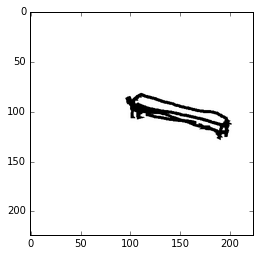

In [155]:
plt.imshow(X_test[-1].reshape(VGG_SIZE_X, VGG_SIZE_Y, VGG_SIZE_Z))

In [156]:
# as first pass
prob = np.squeeze(trained_classifier.predict_proba(_X_test))


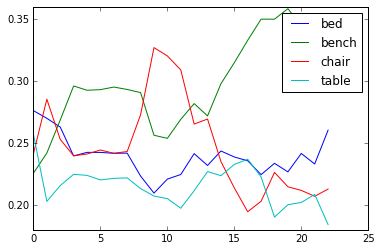

In [149]:
plt.plot(prob)
plt.legend(trained_classifier.classes_)

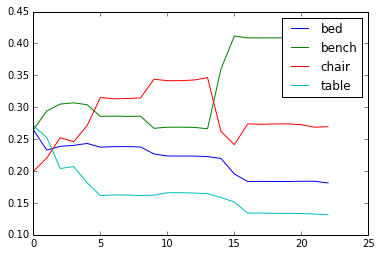

In [144]:
plt.plot(prob)
plt.legend(trained_classifier.classes_)